In [37]:
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
from sklearn.model_selection import train_test_split
from multiprocessing import Pool, Array, cpu_count
from collections import namedtuple

%run kernel_grid.ipynb

print(f'Process ID: {os.getpid()}')
# TODO !!!! image data must be -1, +1 !!!! Otherwise any kernel will perfectly match completely white picture or close

5.02 μs ± 262 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
4.92 μs ± 31.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
Process ID: 1486830


In [38]:
config = Config()

In [39]:
%%time
images = []
image_fnames = {}

for image_fname in tqdm(os.listdir(config.dataset_path)):
    image_fname = os.path.join(config.dataset_path, image_fname)

    # Following fuss with "with" is required to prevent "Too many open files" problem
    with Image.open(image_fname) as image:
        image.load()
        assert image.width == image.height
        assert image.mode == 'L'
        image_index = len(images)
        images.append(np.array(image))
        image_fnames[image_index] = image_fname
        
    assert image.fp is None

assert len(images) == len(image_fnames)
print(f'Loaded {len(images)} images')

  0%|          | 0/9998 [00:00<?, ?it/s]

Loaded 9998 images
CPU times: user 469 ms, sys: 67.7 ms, total: 536 ms
Wall time: 536 ms


In [40]:
def save_grid(grid):
    if not os.path.exists(config.output_path):
        os.mkdir(config.output_path)

    stamp = datetime.now().strftime('%Y-%m-%dT%H:%M:%S')
    output_fname = os.path.join(config.output_path, f'kernel_grid{stamp}.pkl')

    with open(output_fname, 'wb') as output_file:
        pickle.dump(grid, output_file)

    print(f'Grid saved to {output_fname}')

In [41]:
def load_last_grid():
    if not os.path.exists(config.output_path):
        return None

    candidates = []

    for fname in os.listdir(config.output_path):
        try:
            stamp = datetime.strptime(fname, 'kernel_grid%Y-%m-%dT%H:%M:%S.pkl')
            candidates.append([stamp, fname])
        except ValueError:
            print(f'Failed to parse file name {fname}')

    if not candidates:
        return None

    candidates.sort(key=lambda c: c[0], reverse=True)
    fname = os.path.join(config.output_path, candidates[0][1])

    with open(fname, 'rb') as input_file:
        grid = pickle.load(input_file)

    print(f'Grid loaded from {fname}')
    return grid

In [42]:
# global variable used to implement multiprocessing during kernel matching
# read-only access when multiprocessing!!! No synchronization to speed up things!!!
ComputeKernelMatchPulpsCacheContext = namedtuple('ComputeKernelMatchPulpsCacheContext', 'images kernels')
_compute_kernel_match_pulps_cache_context = ComputeKernelMatchPulpsCacheContext

def _compute_kernel_match_pulps_cache_for_ij(ij):
    global _compute_kernel_match_pulps_cache_context
    k = _compute_kernel_match_pulps_cache_context.kernels[ij]
    pulps = []

    for image in _compute_kernel_match_pulps_cache_context.images:
        pulp = k.compute_match_pulp(image)
        pulps.append(pulp)

    return (ij, pulps)

def compute_kernel_match_pulps_cache(grid, images):
    global _compute_kernel_match_pulps_cache_context
    kernels = grid.indices
    _compute_kernel_match_pulps_cache_context.kernels = kernels
    _compute_kernel_match_pulps_cache_context.images = images
    
    workers = max(2, cpu_count())
    
    with Pool(processes=workers) as pool:
        chunk_size = int(grid.size * grid.size / workers)
        # print(f'Started pool with {workers} workers, chunk size = {chunk_size}')
        
        results = pool.map(_compute_kernel_match_pulps_cache_for_ij, kernels.keys(), chunk_size)
        
        cache = [{} for _ in images]

        for ij, pulps in results:
            assert len(cache) == len(pulps)
            for cache_entry, pulp in zip(cache, pulps):
                cache_entry[ij] = pulp

    return cache   

In [43]:
grid = load_last_grid()

if not grid:
    grid = KernelGrid.random(config.kernel_grid_size, config.kernel_size)

In [44]:
def enhance_grid(grid, extinct_waterline):
    assert extinct_waterline > 0 and extinct_waterline < 1
    total_kernels = len(grid.indices.keys())

    # Step 1 (Stillborn). Kill all kernels which are either degenerate (too primitive) or which didn't activate even once
    step1_list = []
    
    for ij, k in grid.indices.items():
        assert k.match_invokes > 0
        ks = k.get_stats()

        if ks.match_invokes_success < 1 or ks.complexity < config.kernel_min_complexity:
            step1_list.append(ij)

    # assert len(step1_list) > 50
    grid.indices.update(map(lambda ij: (ij, None), step1_list)) # remove kernels all at once
    step1_kernels = len(step1_list) # this one must decrease with time
    print(f'Removed {step1_kernels}/{total_kernels} ({step1_kernels/total_kernels*100:.2f}%) kernels on step 1 (degenerate or dormant)')

    # Step 2 (Twins). Remove very similary kernels which are in proximity
    step2_list = set()
    
    for ij, k in grid.indices.items():
        if k is None:
            continue

        for n_ij, n_k in grid.get_neighbours(ij):
            if n_k is None:
                continue
                
            similarity_score = k.compute_similarity(n_k)

            if similarity_score > config.kernel_similarity_threshold:
                if k.get_stats().match_score <= n_k.get_stats().match_score:
                    step2_list.add(ij)

    grid.indices.update(map(lambda ij: (ij, None), step2_list)) # remove kernels all at once
    step2_kernels = len(step2_list) # this one must decrease with time
    print(f'Removed {step2_kernels}/{total_kernels} ({step2_kernels/total_kernels*100:.2f}%) kernels on step 2 (twins)')

    # Step 3 (Loosers). 

    # Step 4 (Preacher). Make live kernels to roam around the grid to spread genes and favor variance

    # Step 5 (Breeding). Spawn new kernels from victorious
    new_kernels = {}
    parented = 0
    
    for ij, k in grid.indices.items():
        if not k is None:
            continue
        
        ns = grid.get_neighbours(ij)
        possible_parents = []
    
        for n_ij, n_k in ns:
            can_spawn_children = not n_k is None
            
            if can_spawn_children:
                assert n_k.match_invokes > 0, n_ij
                possible_parents.append(n_k)
    
        possible_parents.sort(key=lambda k: k.get_stats().match_score, reverse=True)
        parent = None
    
        if possible_parents:
            # TODO randombly pick up parent giving favor to more performant
            parent = possible_parents[0]
    
        if parent:
            new_kernel = parent.spawn_child()
            parented += 1
        else:
            new_kernel = Kernel.random(config.kernel_size) # Autogenesis
    
        new_kernels[ij] = new_kernel
    
    for ij, _ in new_kernels.items():
        assert ij in grid.indices

    grid.indices.update(new_kernels)

    for _, k in grid.indices:
        assert not k is None

    total_births = len(new_kernels.keys())

    if total_births > 0:
        autogenesis = total_births - parented # this one must decrease with time
        print(f'New kernels births {total_births}, parented {parented} ({parented/total_births*100:.2f}%), autogenesis {autogenesis} ({autogenesis/total_births*100:.2f}%)')
    else:
        print('No new kernels born!')
    

    # Step 2. Kill all kernels whose perf score is under extinct_waterline
    # extinct_list_low_match_score = []

    # step1_and_step2_united_extinct_list = set(extinct_list_degenerate + extinct_list_unactivated)

    # if not step1_and_step2_united_extinct_list:
    #     k_match_scores = []
        
    #     for ij, k in grid.indices.items():
    #         ks = k.get_stats()
    #         k_match_scores.append((ks.match_score, k, ij))
    
    #     k_match_scores.sort(key=lambda x: x[0])
    #     hi = int(len(k_match_scores) * extinct_waterline)
    #     assert hi > 0 and hi < len(k_match_scores)
    #     extinct_list = k_match_scores[0:hi]
    #     extinct_list_ijs = set([ij for _1, _2, ji in extinct_list])
    #     assert len(extinct_list) < len(k_match_scores)
    
    # new_kernels = dict()
    
    # for k_perf_score, k, ij in extinct_list:
    #     ns = grid.get_neighbours(ij)
    #     possible_parents = []
    
    #     for n_ij, n_k in ns:
    #         can_spawn_children = True
    #         can_spawn_children = can_spawn_children and not n_ij in extinct_list_ijs
    #         can_spawn_children = can_spawn_children and not isinstance(n_k, FenceKernel)
            
    #         if can_spawn_children:
    #             assert n_k.match_invokes > 0, n_ij
    #             possible_parents.append(n_k)
    
    #     possible_parents.sort(key=lambda k: k.get_stats().match_success_rate, reverse=True)
    #     parent = None
    
    #     if possible_parents:
    #         # TODO randombly pick up parent giving favor to more performant
    #         parent = possible_parents[0]
    
    #     if parent:
    #         new_kernel = parent.spawn_child()
    #     else:
    #         new_kernel = Kernel.random(config.kernel_size)
    
    #     new_kernels[ij] = new_kernel
    
    # for ij, _ in new_kernels.items():
    #     assert ij in grid.indices
        
    # grid.indices.update(new_kernels)

In [45]:
%%time
train_stats = []

# for day in range(config.kernel_grid_evolution_days):
for day in tqdm(range(25)):
    # New day
    grid.reset_stats()
    train_images, _ = train_test_split(images, shuffle=True)
    assert len(train_images) > 0
    pulps_cache = compute_kernel_match_pulps_cache(grid, train_images)
    #pulps_cache = [{} for _ in train_images]
    assert len(train_images) == len(pulps_cache)
        
    for image, image_pulps_cache in zip(train_images, pulps_cache):
        grid.perceive(image, config.kernel_match_threshold, config.kernel_grid_match_threshold, image_pulps_cache)   
    
    assert grid.perceive_invokes > 0
    train_stats.append(grid.get_stats())

    # Night is coming, going to sleep
    # Adjust kernels to better match day impressions
    enhance_grid(grid, 0.1)
    #save_grid(grid)

  0%|          | 0/25 [00:00<?, ?it/s]

Removed 239/256 (93.36%) kernels on step 1 (degenerate or dormant)
Removed 0/256 (0.00%) kernels on step 2 (twins)
New kernels births 239, parented 96 (40.17%), autogenesis 143 (59.83%)
Removed 188/256 (73.44%) kernels on step 1 (degenerate or dormant)
Removed 25/256 (9.77%) kernels on step 2 (twins)
New kernels births 213, parented 148 (69.48%), autogenesis 65 (30.52%)
Removed 166/256 (64.84%) kernels on step 1 (degenerate or dormant)
Removed 46/256 (17.97%) kernels on step 2 (twins)
New kernels births 212, parented 130 (61.32%), autogenesis 82 (38.68%)
Removed 142/256 (55.47%) kernels on step 1 (degenerate or dormant)
Removed 54/256 (21.09%) kernels on step 2 (twins)
New kernels births 196, parented 155 (79.08%), autogenesis 41 (20.92%)
Removed 170/256 (66.41%) kernels on step 1 (degenerate or dormant)
Removed 40/256 (15.62%) kernels on step 2 (twins)
New kernels births 210, parented 147 (70.00%), autogenesis 63 (30.00%)
Removed 156/256 (60.94%) kernels on step 1 (degenerate or dorma

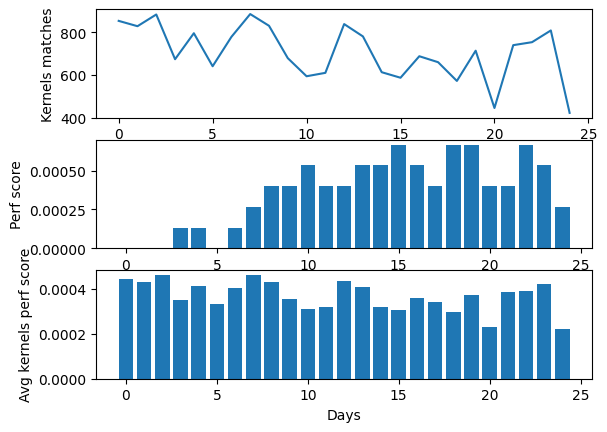

In [52]:
fig, ax = plt.subplots(3)
days_count = len(train_stats)

ax[0].plot(list(range(days_count)), [ts.kernel_matches for ts in train_stats])
ax[0].set_ylabel('Kernels matches')

ax[1].bar(list(range(days_count)), [ts.perceive_success_rate for ts in train_stats])
ax[1].set_ylabel('Perf score')

ax[2].bar(list(range(days_count)), [ts.kernels_match_success_rates.mean for ts in train_stats])
ax[2].set_xlabel('Days')
ax[2].set_ylabel('Avg kernels perf score')
plt.show()

In [47]:
grid.reset_stats()
_, test_images = train_test_split(images, shuffle=True)
test_images = train_images

for image in tqdm(test_images):
    grid.perceive(image, config.kernel_match_threshold, config.kernel_grid_match_threshold)

  0%|          | 0/7498 [00:00<?, ?it/s]


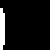
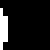
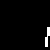
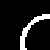
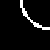
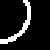
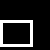
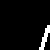
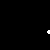
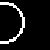
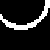
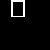
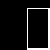
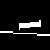
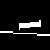
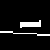
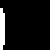
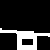
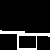
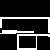
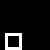
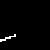
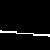
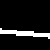
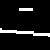
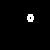
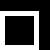
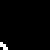
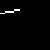
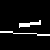
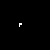
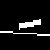
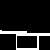
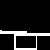
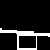
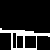
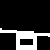
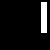
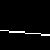
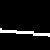
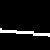
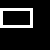
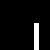
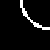
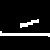
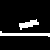
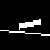
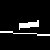
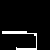
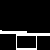
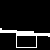
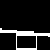
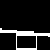
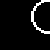
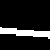
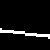
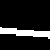
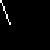
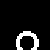
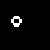
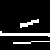
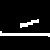
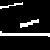
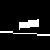
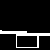
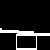
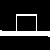
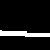
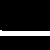
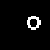
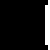
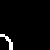
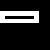
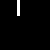
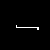
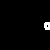
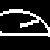
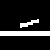
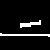
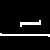
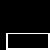
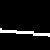
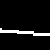
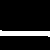
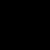
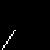
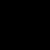
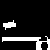
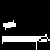
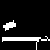
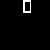
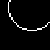
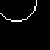
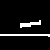
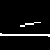
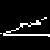
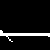
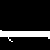
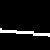
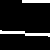
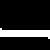
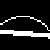
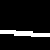
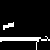
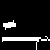
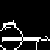
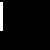
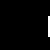
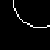
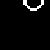
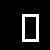
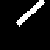
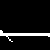
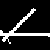
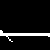
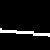
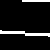
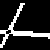
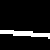
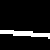
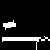
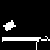
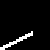
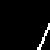
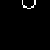
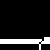
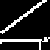
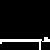
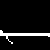
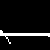
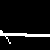
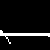
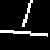
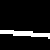
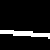
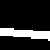
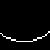
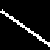
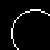
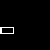
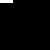
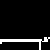
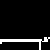
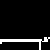
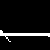
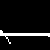
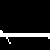
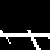
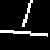
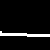
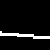
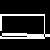
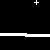
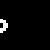
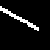
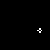
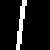
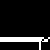
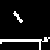
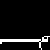
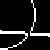
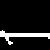
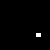
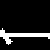
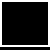
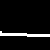
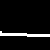
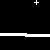
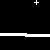
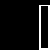
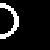
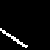
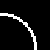
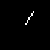
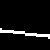
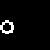
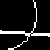
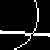
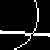
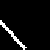
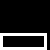
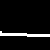
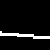
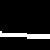
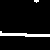
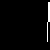
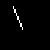
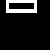
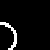
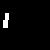
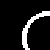
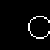
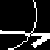
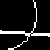
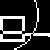
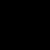
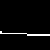
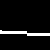
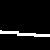
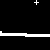
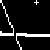
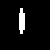
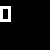
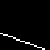
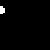
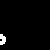
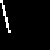
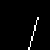
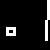
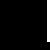
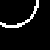
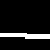
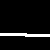
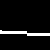
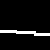
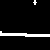
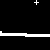
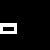
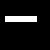
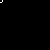
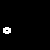
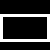
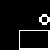
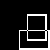
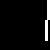
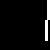
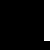
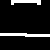
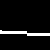
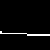
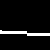
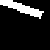
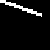
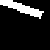
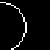
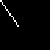
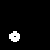
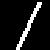
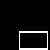
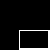
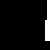
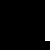
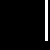
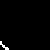
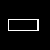
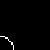
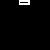
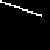
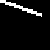
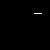
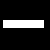
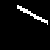
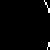
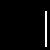
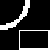
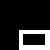

In [48]:
if True:
    kernel_images = grid.get_kernel_images(2)
    _images = []
    _captions = {}
    
    for i, ki_row in enumerate(kernel_images):
        for j, ki in enumerate(ki_row):
            _image = ki.image.resize((50, 50))
            _images.append(_image)
            _captions[id(_image)] = f'{(i,j)} {ki.kernel.get_stats().match_invokes_success}'
else:
    kernel_images = grid.get_kernel_images(1)
    kernel_images.sort(key=lambda ki: ki.kernel.get_stats().match_success_rate, reverse=True)
    _images = []
    _captions = {}

    for ki in kernel_images:
        _image = ki.image.resize((50, 50))
        _images.append(_image)
        _captions[id(_image)] = f'{ki.ij} {ki.kernel.get_stats().match_invokes_success}'

display_images_grid(_images, grid.size, captions=_captions)

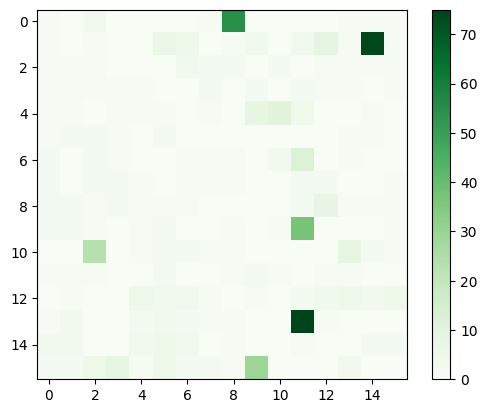

In [49]:
grid_heatmap_data = np.full((grid.size,grid.size), 0, dtype=np.float32)
max_match_invokes_success = None

for ij, k in grid.indices.items():
    x = k.get_stats().match_invokes_success
    
    if max_match_invokes_success is None or x > max_match_invokes_success:
        max_match_invokes_success = x

    grid_heatmap_data[ij] = float(x)

#grid_heatmap_data /= max_match_invokes_success
# colormaps https://matplotlib.org/stable/users/explain/colors/colormaps.html
plt.imshow(grid_heatmap_data, cmap='Greens', interpolation='nearest', origin='upper')
plt.colorbar() 
plt.show()

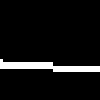

In [50]:
grid.indices[(14, 6)].to_image(inverted=False).resize((100, 100))